#**Import Libraries**

In [ ]:
#Step 1: Imports and Dataset Unzipping
import os
import zipfile
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# **Loading the Dataset**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Unzip the dataset
zip_path = "/content/CV_FINAL_PROJECT_DATASET.zip"
extract_path = "/content/CV_FINAL_PROJECT_DATASET"
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(" Dataset extracted!")
else:
    print(" Dataset already extracted!")

# Setup path
DATASET_PATH = extract_path

 Dataset extracted!


# **Data Preprocessing**

In [ ]:
# Augmentation transform for training set
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(44),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Base transform for test and validation sets (no augmentation)
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Apply transforms
train_dataset = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "train"), transform=train_transform)
test_dataset  = datasets.ImageFolder(root=os.path.join(DATASET_PATH, "test"), transform=train_transform)

# Store class names
class_names = train_dataset.classes


# **Merging the train_dataset and the test_dataset in a single dataset**

In [ ]:
from torch.utils.data import ConcatDataset

# Merge train and test datasets into one
full_dataset = ConcatDataset([train_dataset, test_dataset])
print("Now full_data set contains all the data points.")

Now full_data set contains all the data points.


# **Class distribution of the entire dataset**

📋 Class Counts Table (including Total):


,Class,Count
0,happy,8989
1,neutral,6198
2,sad,6077
3,fear,5121
4,angry,4953
5,surprise,4002
6,disgust,547
7,Total,35887


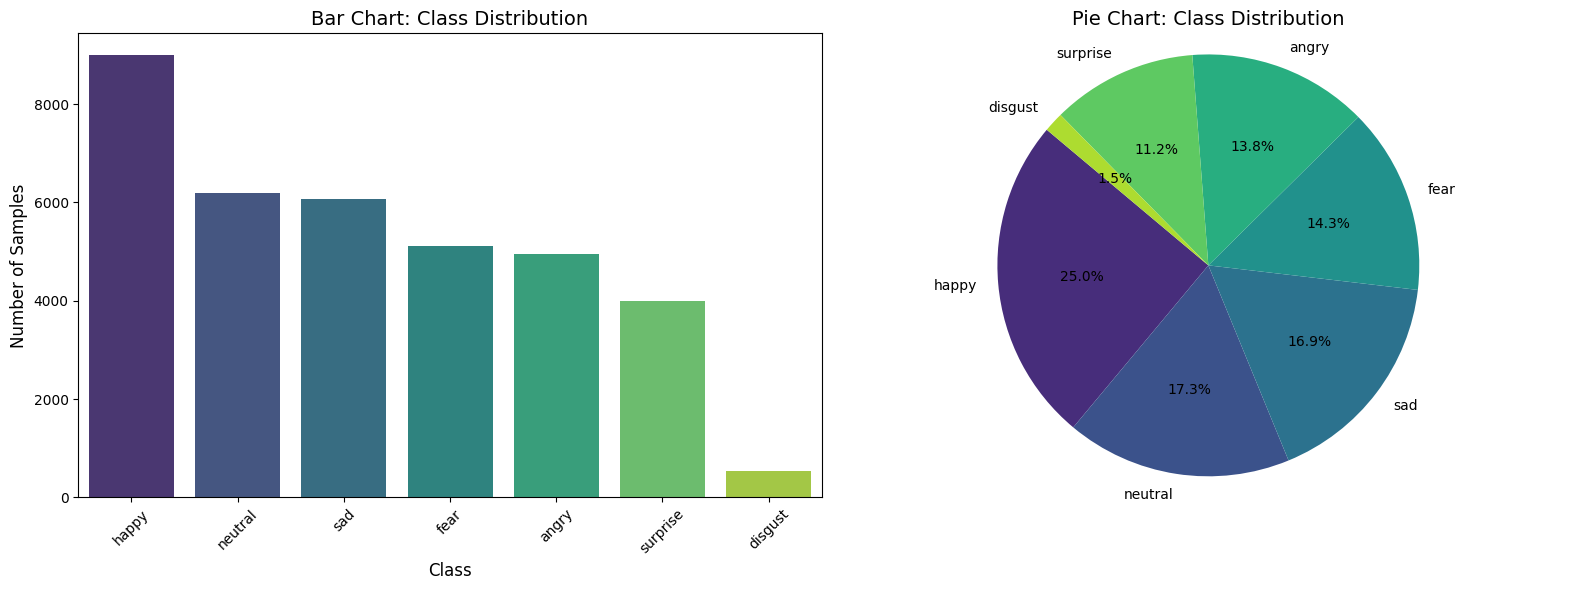

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Get class distribution from full_dataset
all_labels = [label for _, label in full_dataset]
class_counts = Counter(all_labels)

# Step 2: Convert to DataFrame
class_counts_df = pd.DataFrame(class_counts.items(), columns=["Class", "Count"])
class_counts_df["Class"] = class_counts_df["Class"].apply(lambda x: class_names[x])
class_counts_df = class_counts_df.sort_values("Count", ascending=False)

# Step 3: Add total row
total_data_points = class_counts_df["Count"].sum()
total_row = pd.DataFrame([["Total", total_data_points]], columns=["Class", "Count"])
class_counts_table = pd.concat([class_counts_df, total_row], ignore_index=True)

# Step 4: Display table
print("📋 Class Counts Table (including Total):")
display(class_counts_table)

# Step 5: Visualization
class_counts_for_plotting = class_counts_df[class_counts_df["Class"] != "Total"]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Bar Plot
sns.barplot(
    data=class_counts_for_plotting,
    x="Class",
    y="Count",
    hue="Class",
    dodge=False,
    palette="viridis",
    ax=axs[0],
    legend=False
)
axs[0].set_title("Bar Chart: Class Distribution", fontsize=14)
axs[0].set_xlabel("Class", fontsize=12)
axs[0].set_ylabel("Number of Samples", fontsize=12)
axs[0].tick_params(axis='x', rotation=45)

# Pie Chart
axs[1].pie(
    class_counts_for_plotting["Count"],
    labels=class_counts_for_plotting["Class"],
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("viridis", len(class_counts_for_plotting))
)
axs[1].set_title("Pie Chart: Class Distribution", fontsize=14)
axs[1].axis("equal")

plt.tight_layout()
plt.show()


# **Sample images from the Dataset**

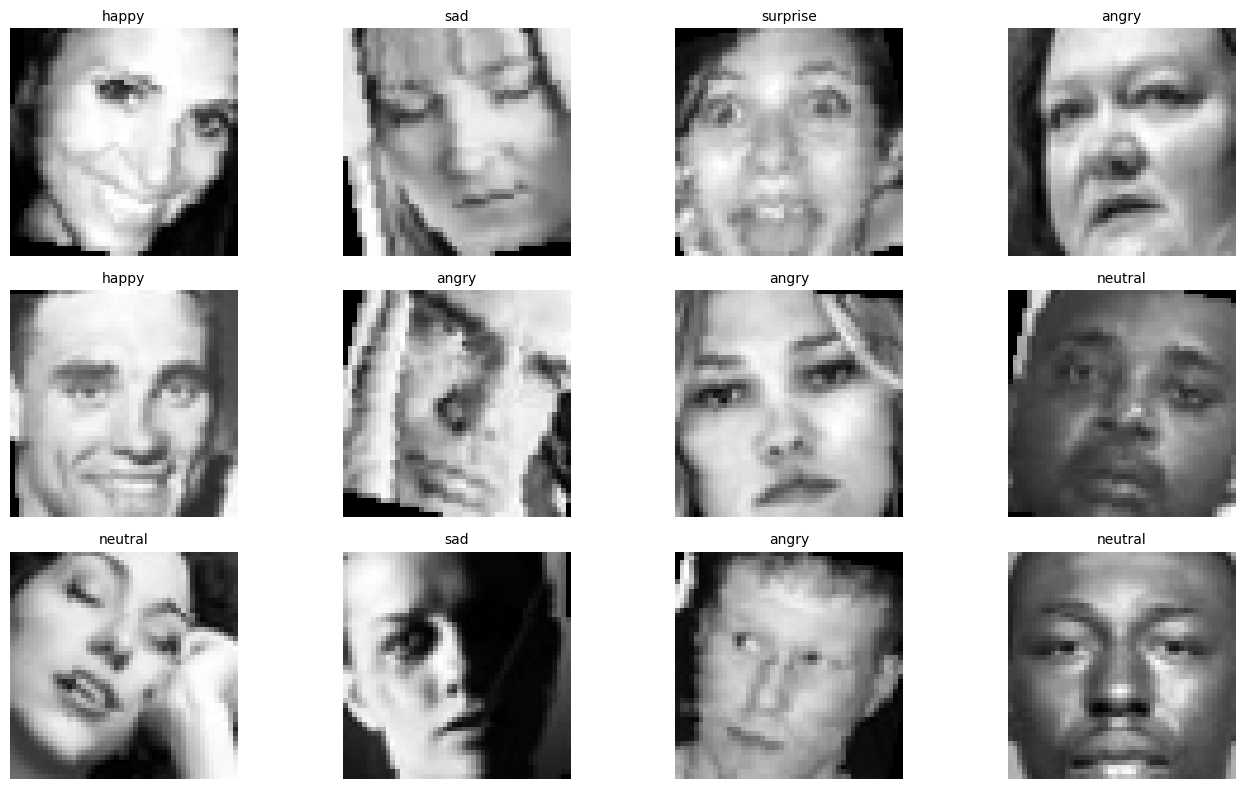

In [ ]:
import matplotlib.pyplot as plt
import random
import torch

# Assuming you have this mapping for class labels
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Plotting
plt.figure(figsize=(14, 8))

# Randomly select 12 samples to plot
for i in range(12):
    idx = random.randint(0, len(full_dataset) - 1)
    img, label = full_dataset[idx]

    # If image is a Tensor, convert to numpy for plotting
    if isinstance(img, torch.Tensor):
        img = img * 0.5 + 0.5  # Unnormalize if it was normalized (only if needed)
        img = img.squeeze(0)   # Remove channel dimension if grayscale

    plt.subplot(3, 4, i + 1)
    plt.imshow(img.numpy(), cmap='gray')
    plt.title(class_names[label], fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

# **Data augmentation on the entire dataset**

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
import random
from collections import Counter
import torch
from PIL import Image

# --- Realistic and Gentle Strong Augmentation ---
strong_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=10),
        transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), shear=5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.01),
        transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
    ], p=0.7),
    transforms.Resize((48, 48)),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# --- Custom Dataset Class ---
class StrongAugmentedDataset(Dataset):
    def __init__(self, original_dataset, transform):
        self.original_dataset = original_dataset
        self.transform = transform

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        img, label = self.original_dataset[idx]
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)
        img = self.transform(img)
        return img, label

# --- Balancing the Dataset with More Samples (~100,000 total) ---
def balance_dataset(dataset, transform):
    class_counts = Counter([label for _, label in dataset])
    target_count_per_class = 14285  # 100,000 / 7 classes

    balanced_data = []

    for class_idx in range(len(class_counts)):
        class_samples = [sample for sample in dataset if sample[1] == class_idx]
        needed = target_count_per_class - len(class_samples)

        augmented_samples = []
        while len(augmented_samples) < needed:
            img, label = random.choice(class_samples)

            if isinstance(img, torch.Tensor):
                img = transforms.ToPILImage()(img)

            img = transform(img)
            augmented_samples.append((img, label))

        # Add original samples
        for img, label in class_samples:
            if isinstance(img, torch.Tensor):
                img = transforms.ToPILImage()(img)
            balanced_data.append((img, label))

        # Add augmented samples
        balanced_data.extend(augmented_samples)

    return balanced_data

# --- Applying Strong Augmentation and Balancing ---
balanced_augmented_data = balance_dataset(full_dataset, strong_augmentation)
augmented_full_dataset = StrongAugmentedDataset(balanced_augmented_data, strong_augmentation)

print("Realistic and Gentle Strongly Augmented and Balanced Dataset Created!")


Realistic and Gentle Strongly Augmented and Balanced Dataset Created!


# **Class distribution of the augmnented dataset**

<ipython-input-29-74edbe5cd669>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=class_counts_df, palette='viridis', ax=axs[0])


Class Counts Table (including Total):
      Class  Count
0     angry  14285
1   disgust  14285
2      fear  14285
3     happy  14285
4   neutral  14285
5       sad  14285
6  surprise  14285
7     Total  99995


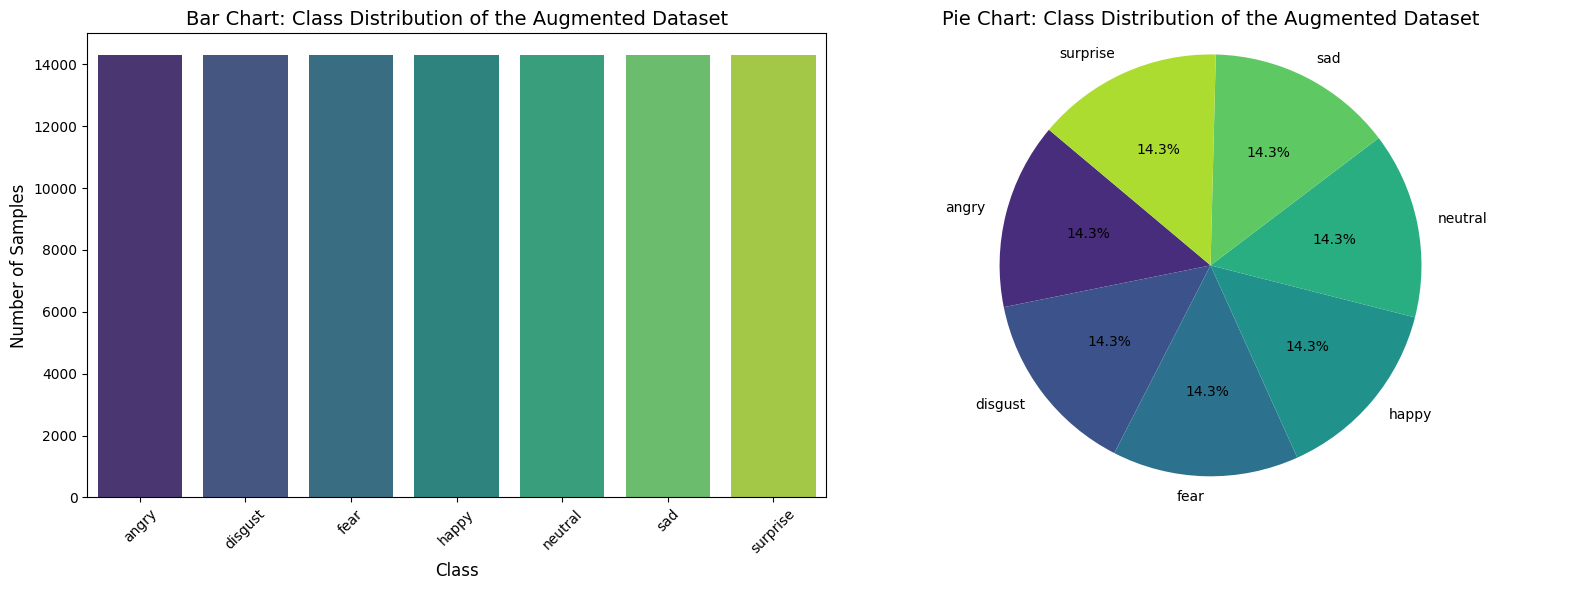

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

# --- Count the occurrences of each class in the augmented_full_dataset ---
augmented_class_counts = Counter()

# Loop over the augmented_full_dataset
for _, label in augmented_full_dataset:
    augmented_class_counts[label] += 1

# Create a DataFrame for easy plotting
class_counts_df = pd.DataFrame({
    'Class': [class_names[class_idx] for class_idx in augmented_class_counts.keys()],
    'Count': list(augmented_class_counts.values())
})

# Add total row to the table (excluding from pie and bar chart)
total_count = class_counts_df['Count'].sum()
total_row = pd.DataFrame([['Total', total_count]], columns=['Class', 'Count'])
class_counts_table = pd.concat([class_counts_df, total_row], ignore_index=True)

# Create figure with 2 subplots (Bar chart and Pie chart)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot for class distribution
sns.barplot(x='Class', y='Count', data=class_counts_df, palette='viridis', ax=axs[0])
axs[0].set_title('Bar Chart: Class Distribution of the Augmented Dataset', fontsize=14)
axs[0].set_xlabel('Class', fontsize=12)
axs[0].set_ylabel('Number of Samples', fontsize=12)
axs[0].tick_params(axis='x', rotation=45)

# Pie chart for class distribution
axs[1].pie(
    class_counts_df['Count'],
    labels=class_counts_df['Class'],
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("viridis", len(class_counts_df))
)
axs[1].set_title('Pie Chart: Class Distribution of the Augmented Dataset', fontsize=14)
axs[1].axis("equal")  # Equal aspect ratio ensures the pie chart is circular.

plt.tight_layout()

# Display the table with total count (excluding from bar and pie charts)
print("Class Counts Table (including Total):")
print(class_counts_table)

# Show all plots
plt.show()


# **Spliting the dataset for Training, Validation and Testing**

In [ ]:
from sklearn.model_selection import train_test_split
import torch

# First, manually extract the images and labels
all_imgs = []
all_labels = []

for img, label in augmented_full_dataset:
    all_imgs.append(img)
    all_labels.append(label)

# Step 1: First split into 90% train and 10% temp (val + test)
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    all_imgs, all_labels, test_size=0.1, stratify=all_labels, random_state=42
)

# Step 2: Split temp into 50% val and 50% test (each will be 5% of full data)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Create TensorDatasets
train_dataset = torch.utils.data.TensorDataset(torch.stack(train_imgs), torch.tensor(train_labels))
val_dataset = torch.utils.data.TensorDataset(torch.stack(val_imgs), torch.tensor(val_labels))
test_dataset = torch.utils.data.TensorDataset(torch.stack(test_imgs), torch.tensor(test_labels))

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 89995
Validation dataset size: 5000
Test dataset size: 5000


# **Class Distribution of Train Set**

In [ ]:
from collections import Counter

# Count the occurrences of each class in the train dataset
train_class_counts = Counter([int(label) for _, label in train_dataset])

# Print class distribution in the desired format
print("Class distribution in the train dataset:")
for class_idx, count in train_class_counts.items():
    print(f"Class {class_names[class_idx]}: {count}")


Class distribution in the train dataset:
Class surprise: 12856
Class sad: 12857
Class happy: 12856
Class fear: 12856
Class angry: 12857
Class disgust: 12857
Class neutral: 12856


<ipython-input-33-45b3af7143ab>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_class_df, x='Class', y='Count', palette='viridis', ax=axes[0])


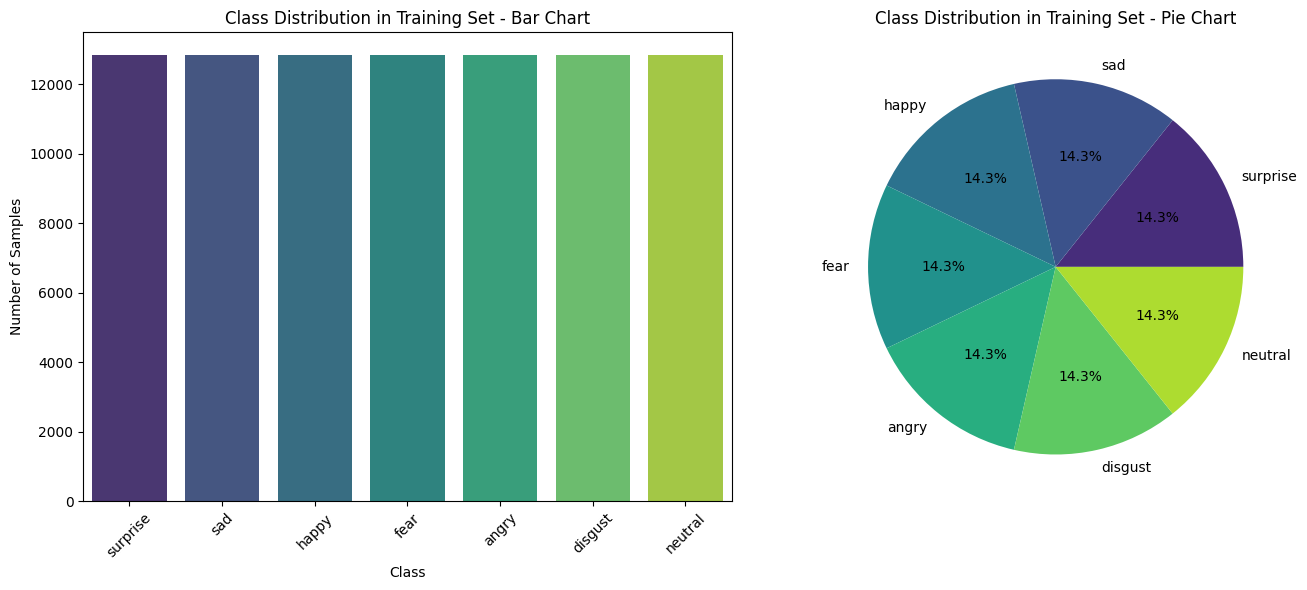

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

# Get labels from the second tensor of the dataset
train_labels = train_dataset.tensors[1].tolist()

# Count class occurrences
train_class_counts = Counter(train_labels)

# Convert to DataFrame for visualization
train_class_df = pd.DataFrame({
    'Class': [class_names[i] for i in train_class_counts.keys()],
    'Count': list(train_class_counts.values())
})

# Plot bar and pie charts side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot
sns.barplot(data=train_class_df, x='Class', y='Count', palette='viridis', ax=axes[0])
axes[0].set_title('Class Distribution in Training Set - Bar Chart')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
axes[1].pie(train_class_df['Count'], labels=train_class_df['Class'], autopct='%1.1f%%', colors=sns.color_palette('viridis', len(train_class_df)))
axes[1].set_title('Class Distribution in Training Set - Pie Chart')

plt.tight_layout()
plt.show()

# **Class Distribution of Validation Set**

In [ ]:
# Count the occurrences of each class in the validation dataset
val_class_counts = Counter([int(label.item()) for _, label in val_dataset])  # Correct extraction

# Print class distribution in the desired format
print("Class distribution in the validation dataset:")
for class_idx, count in val_class_counts.items():
    print(f"Class {class_names[class_idx]}: {count}")


Class distribution in the validation dataset:
Class surprise: 715
Class happy: 715
Class angry: 714
Class sad: 714
Class disgust: 714
Class fear: 714
Class neutral: 714


<ipython-input-35-a7833c60cb17>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=val_class_df, x='Class', y='Count', palette='viridis', ax=axes[0])


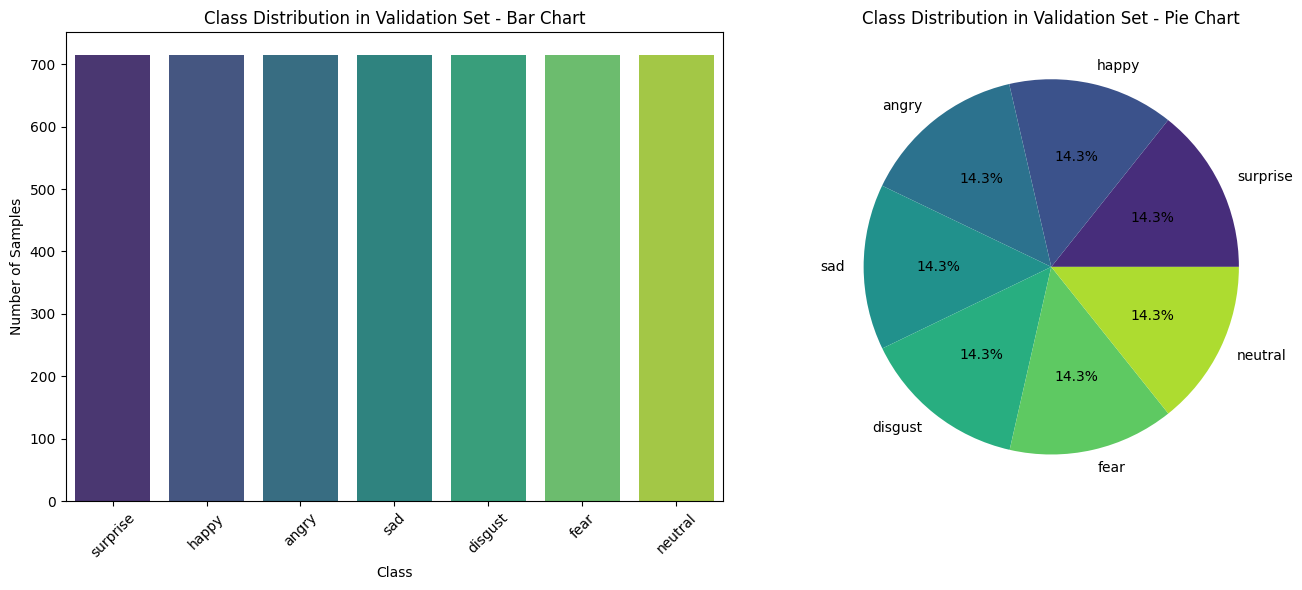

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

# Count class occurrences in validation dataset
val_class_counts = Counter([int(label.item()) for _, label in val_dataset])

# Create DataFrame for visualization
val_class_df = pd.DataFrame({
    'Class': [class_names[i] for i in val_class_counts.keys()],
    'Count': list(val_class_counts.values())
})

# Plot bar and pie charts side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot
sns.barplot(data=val_class_df, x='Class', y='Count', palette='viridis', ax=axes[0])
axes[0].set_title('Class Distribution in Validation Set - Bar Chart')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
axes[1].pie(val_class_df['Count'], labels=val_class_df['Class'], autopct='%1.1f%%', colors=sns.color_palette('viridis', len(val_class_df)))
axes[1].set_title('Class Distribution in Validation Set - Pie Chart')

plt.tight_layout()
plt.show()


# **Class Distribution of Test Set**

In [ ]:
# Count the occurrences of each class in the test dataset
test_class_counts = Counter([int(label.item()) for _, label in test_dataset])  # Correct extraction

# Print class distribution in the desired format
print("Class distribution in the test dataset:")
for class_idx, count in test_class_counts.items():
    print(f"Class {class_names[class_idx]}: {count}")


Class distribution in the test dataset:
Class angry: 714
Class surprise: 714
Class disgust: 714
Class sad: 714
Class happy: 714
Class fear: 715
Class neutral: 715


<ipython-input-37-17d8c2341daf>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=test_class_df, x='Class', y='Count', palette='viridis', ax=axes[0])


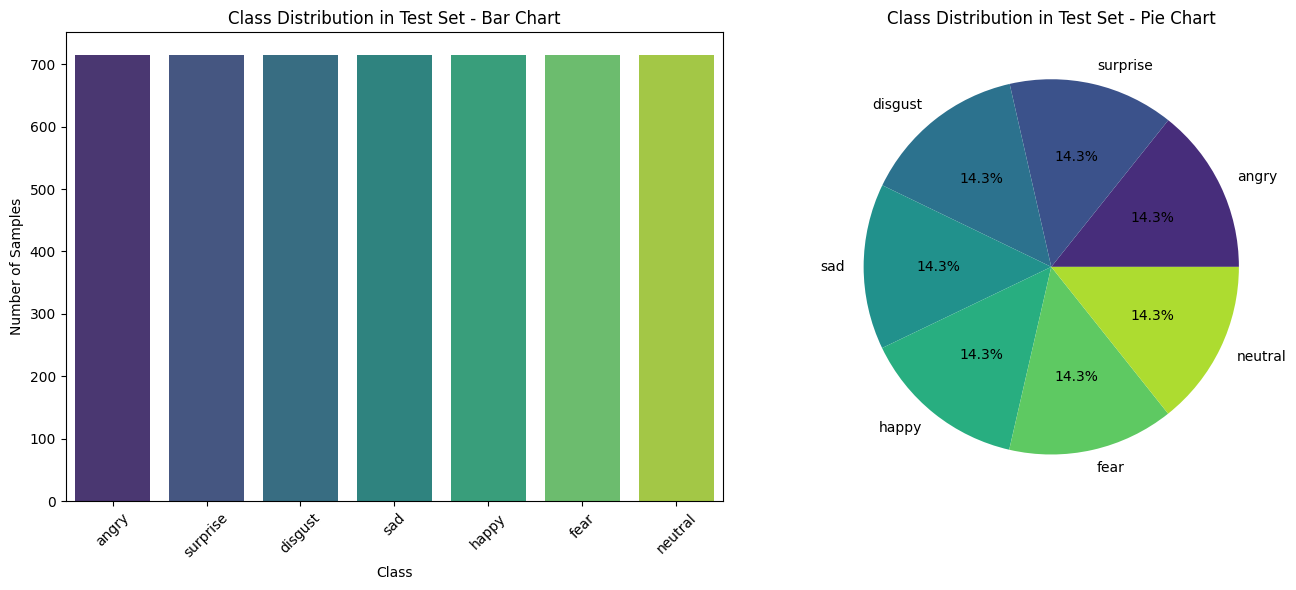

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

# Count the occurrences of each class in the test dataset
test_class_counts = Counter([int(label.item()) for _, label in test_dataset])

# Create DataFrame for plotting
test_class_df = pd.DataFrame({
    'Class': [class_names[i] for i in test_class_counts.keys()],
    'Count': list(test_class_counts.values())
})

# Plot bar and pie charts in a single row
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart
sns.barplot(data=test_class_df, x='Class', y='Count', palette='viridis', ax=axes[0])
axes[0].set_title('Class Distribution in Test Set - Bar Chart')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
axes[1].pie(test_class_df['Count'], labels=test_class_df['Class'], autopct='%1.1f%%',
            colors=sns.color_palette('viridis', len(test_class_df)))
axes[1].set_title('Class Distribution in Test Set - Pie Chart')

plt.tight_layout()
plt.show()

# **Check if train_dataset images are in grayscale**

In [ ]:
# Get a sample image from the train dataset
sample_image, _ = train_dataset[0]   # use train_dataset, not train_data

# Check the number of channels in the image
if sample_image.shape[0] == 1:
    print("Images in the train dataset are in grayscale.")
else:
    print("Images in the train dataset are not in grayscale.")


Images in the train dataset are in grayscale.


# **Check if val_dataset images are in grayscale**

In [ ]:
# Get a sample image from the validation dataset
sample_image, _ = val_dataset[0]   # use val_dataset, not val_data

# Check the number of channels in the image
if sample_image.shape[0] == 1:
    print("Images in the validation dataset are in grayscale.")
else:
    print("Images in the validation dataset are not in grayscale.")


Images in the validation dataset are in grayscale.


# **Check if test_dataset images are in grayscale**

In [ ]:
# Get a sample image from the test dataset
sample_image, _ = test_dataset[0]   # use test_dataset, not test_data

# Check the number of channels in the image
if sample_image.shape[0] == 1:
    print("Images in the test dataset are in grayscale.")
else:
    print("Images in the test dataset are not in grayscale.")



Images in the test dataset are in grayscale.


# **DataLoader : smart batch-maker from a Dataset.**


In [ ]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim   # <-- ADD THIS
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Assuming you already have train_dataset, val_dataset, and test_dataset ready
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# **CNN Model Definition**

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary

# Model definition
class FixedEmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(FixedEmotionCNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 512),  # 48x48 input -> 6x6 after pooling
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate
model = FixedEmotionCNN(num_classes=7)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss() #Loss Function

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# **Model Summary**

In [ ]:
!pip install torchinfo
from torchinfo import summary

summary(model,
        input_size=(64, 1, 48, 48),  # Batch size 64, 1 channel (grayscale), 48x48 image
        col_names=["kernel_size", "input_size", "output_size", "num_params"],
        depth=3)  # Increase depth to see nested layers

Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #
FixedEmotionCNN                          --                        [64, 1, 48, 48]           [64, 7]                   --
├─Sequential: 1-1                        --                        [64, 1, 48, 48]           [64, 256, 6, 6]           --
│    └─Conv2d: 2-1                       [3, 3]                    [64, 1, 48, 48]           [64, 64, 48, 48]          640
│    └─BatchNorm2d: 2-2                  --                        [64, 64, 48, 48]          [64, 64, 48, 48]          128
│    └─ReLU: 2-3                         --                        [64, 64, 48, 48]          [64, 64, 48, 48]          --
│    └─Conv2d: 2-4                       [3, 3]                    [64, 64, 48, 48]          [64, 64, 48, 48]          36,928
│    └─BatchNorm2d: 2-5                  --                        [64, 64, 48, 48]          [64, 64, 48, 48]          128
│    └─ReLU:

# **Training**

Epoch [1/40] | Train Loss: 1.7137 | Train Acc: 32.71% | Val Loss: 1.5641 | Val Acc: 38.82% | Time: 49.45s
Current LR: 0.001000
Epoch [2/40] | Train Loss: 1.5053 | Train Acc: 42.16% | Val Loss: 1.4286 | Val Acc: 45.24% | Time: 47.36s
Current LR: 0.001000
Epoch [3/40] | Train Loss: 1.4072 | Train Acc: 46.38% | Val Loss: 1.3694 | Val Acc: 47.74% | Time: 48.45s
Current LR: 0.001000
Epoch [4/40] | Train Loss: 1.3318 | Train Acc: 49.25% | Val Loss: 1.3006 | Val Acc: 49.76% | Time: 48.41s
Current LR: 0.001000
Epoch [5/40] | Train Loss: 1.2682 | Train Acc: 51.91% | Val Loss: 1.2447 | Val Acc: 51.78% | Time: 48.37s
Current LR: 0.001000
Epoch [6/40] | Train Loss: 1.2149 | Train Acc: 54.02% | Val Loss: 1.2003 | Val Acc: 53.60% | Time: 48.42s
Current LR: 0.001000
Epoch [7/40] | Train Loss: 1.1673 | Train Acc: 55.75% | Val Loss: 1.1770 | Val Acc: 54.66% | Time: 48.37s
Current LR: 0.001000
Epoch [8/40] | Train Loss: 1.1275 | Train Acc: 57.29% | Val Loss: 1.1423 | Val Acc: 56.66% | Time: 48.33s
Curre

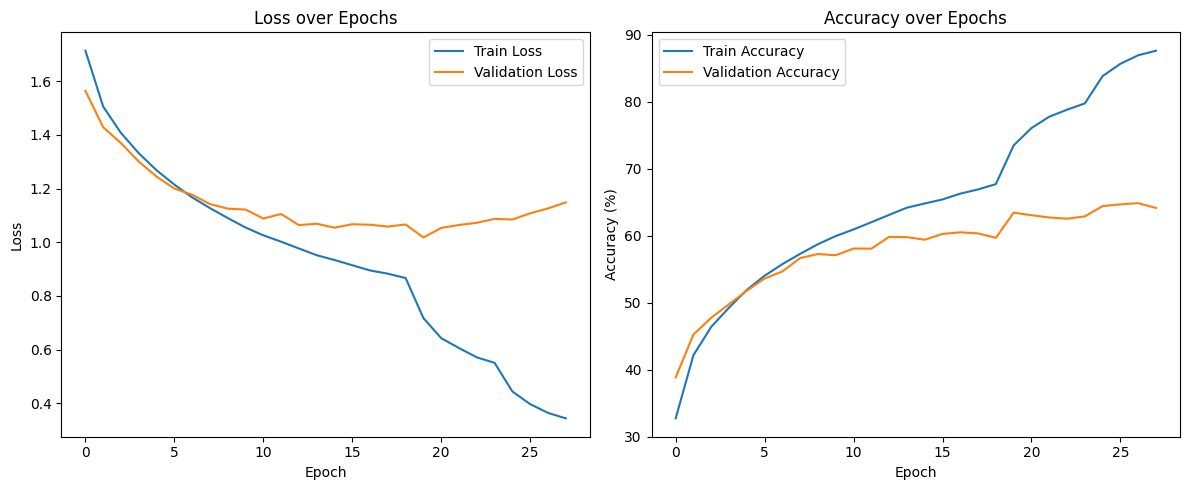

In [ ]:
import torch
import matplotlib.pyplot as plt
import time

# Training settings
num_epochs = 40
patience = 8  # Early stopping patience
best_val_loss = float('inf')
early_stop_counter = 0

# Initialize lists for tracking losses and accuracies
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    running_corrects = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * running_corrects / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_corrects += (outputs.argmax(dim=1) == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = 100 * val_corrects / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
          f"Time: {time.time() - start_time:.2f}s")

    for param_group in optimizer.param_groups:
        print(f"Current LR: {param_group['lr']:.6f}")

    # Early Stopping and Model Saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered!")
            break

# Plotting loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


# **Loading the trained parameters (weights and biases) into our model architecture.**

In [ ]:
# trained_model_path="/content/drive/MyDrive/CV Final Project (Sem 2)/best_model.pth"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.load_state_dict(torch.load(trained_model_path, map_location=device))
# model.to(device)

# **Testing**

In [ ]:
from torch.utils.data import DataLoader

# Assuming test_dataset is already defined
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Put model in evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

test_loss = 0
test_correct = 0
total_samples = len(test_dataset)
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        test_correct += (outputs.argmax(1) == labels).sum().item()

test_accuracy = 100 * test_correct / total_samples
avg_test_loss = test_loss / total_samples

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Loss: {avg_test_loss:.4f}")

Test Accuracy: 64.44%
Test Loss: 1.1338


# **Model Evaluation**

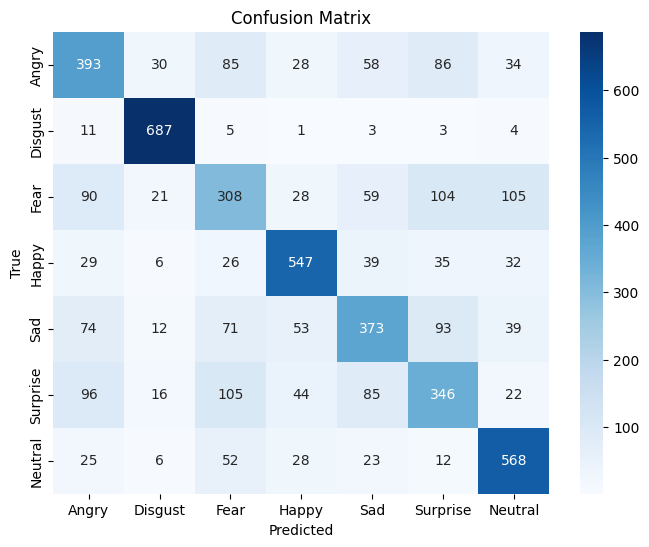

 Classification Report:
              precision    recall  f1-score   support

       Angry       0.55      0.55      0.55       714
     Disgust       0.88      0.96      0.92       714
        Fear       0.47      0.43      0.45       715
       Happy       0.75      0.77      0.76       714
         Sad       0.58      0.52      0.55       715
    Surprise       0.51      0.48      0.50       714
     Neutral       0.71      0.80      0.75       714

    accuracy                           0.64      5000
   macro avg       0.64      0.64      0.64      5000
weighted avg       0.64      0.64      0.64      5000



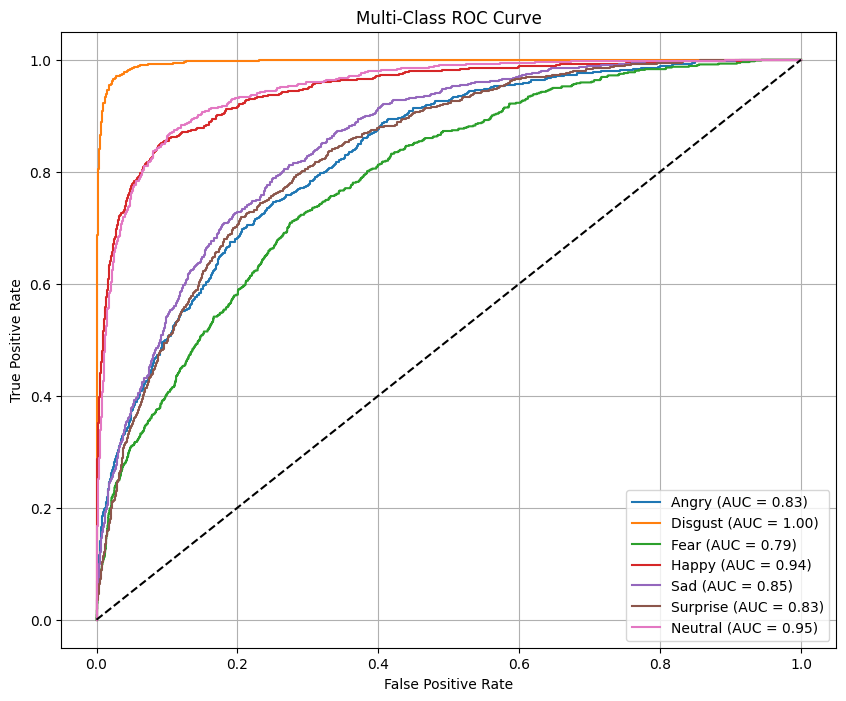

In [ ]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Collect predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convert predictions to class labels
pred_probs = np.array(all_preds)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = np.array(all_labels)

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report (Precision, Recall, F1)
print(" Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_names))

#  ROC Curve and AUC for Multi-Class
# Binarize true labels
true_binarized = label_binarize(true_labels, classes=list(range(len(class_names))))
n_classes = len(class_names)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_binarized[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.grid()
plt.show()


# **Live Demo**

In [ ]:
# Install necessary package
!pip install -q opencv-python-headless

# Imports
import cv2
import torch
import torchvision.transforms as transforms
from PIL import Image
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# Function to capture photo using webcam
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = '📷 Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        div.appendChild(video);
        document.body.appendChild(div);

        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);

        stream.getTracks().forEach(track => track.stop());
        div.remove();

        return canvas.toDataURL('image/jpeg', quality);
      }
    ''')
    display(js)
    data = eval_js(f'takePhoto({quality})')
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Function to detect and crop face
def detect_and_crop_face(image_path, output_size=(48, 48), save_cropped_path='cropped_face.jpg'):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) == 0:
        print("No face detected. Returning resized original image.")
        face_resized = cv2.resize(gray, output_size)
    else:
        (x, y, w, h) = faces[0]  # Take the first detected face
        face = gray[y:y+h, x:x+w]
        face_resized = cv2.resize(face, output_size)

    # Save the cropped face
    cropped_face = Image.fromarray(face_resized)
    cropped_face.save(save_cropped_path)

    return cropped_face, save_cropped_path  # return both image and saved path

# Function to predict emotion
def predict_emotion(image, model, transform, class_names):
    device = next(model.parameters()).device  # Automatically get model's device (cpu or cuda)
    image = transform(image).unsqueeze(0).to(device)  # Move input image to same device
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return class_names[predicted.item()]

# ----- Main Program -----

# 1. Load model and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = YourModelClass()
# model.load_state_dict(torch.load('your_model.pth', map_location=device))
# model.to(device)
# model.eval()

# 2. Take photo
image_path = take_photo()

# 3. Detect and crop face
cropped_face, cropped_face_path = detect_and_crop_face(image_path)

# 4. Define same transform as training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # for grayscale images
])

# 5. Define emotion classes
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# 6. Predict emotion
predicted_emotion = predict_emotion(cropped_face, model, transform, class_names)

# 7. Display results
print(f"Predicted Emotion: {predicted_emotion}")
print(f"Cropped face saved at: {cropped_face_path}")
cropped_face.show()


<IPython.core.display.Javascript object>

Predicted Emotion: Angry
Cropped face saved at: cropped_face.jpg
